In [21]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [22]:
tickers = ['BTC','SOL','LINK','LTC','UNI','VET']
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

In [23]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [25]:
#log_returns = log_returns.dropna()

In [26]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           BTC       SOL      LINK       LTC          UNI       VET
BTC   0.001392  0.002926 -0.000211  0.001256     0.000962 -0.001010
SOL   0.002926  0.874495 -0.016111  0.027054     0.010865  0.079842
LINK -0.000211 -0.016111  0.463099  0.008732     0.114427  0.031158
LTC   0.001256  0.027054  0.008732  0.051275    -1.004799  0.029206
UNI   0.000962  0.010865  0.114427 -1.004799  1101.202903  1.420500
VET  -0.001010  0.079842  0.031158  0.029206     1.420500  0.355835


In [27]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [28]:
# Objective function for optimization (negative Sharpe ratio for maximization)
def objective_function(weights, log_returns, cov_matrix, risk_free_rate, mode='maximize_sharpe'):
    if mode == 'maximize_sharpe':
        return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)
    elif mode == 'minimize_volatility':
        return standard_deviation(weights, cov_matrix)

In [29]:
risk_free_rate = .02

#def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    #return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

#optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

Analyze the Optimal Portfolio

In [30]:
# Optimization for highest Sharpe ratio
optimized_results_sharpe = minimize(objective_function, initial_weights, args=(log_returns, cov_matrix, risk_free_rate, 'maximize_sharpe'), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights_sharpe = optimized_results_sharpe.x

# Optimization for lowest volatility (risk)
optimized_results_volatility = minimize(objective_function, initial_weights, args=(log_returns, cov_matrix, risk_free_rate, 'minimize_volatility'), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights_volatility = optimized_results_volatility.x

# Print optimal weights and portfolio statistics for highest Sharpe ratio
print("Optimal Weights (Highest Sharpe Ratio):")
for ticker, weight in zip(tickers, optimal_weights_sharpe):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return_sharpe = expected_return(optimal_weights_sharpe, log_returns)
optimal_portfolio_volatility_sharpe = standard_deviation(optimal_weights_sharpe, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights_sharpe, log_returns, cov_matrix, risk_free_rate)

print(f"\nExpected Annual Return (Highest Sharpe Ratio): {optimal_portfolio_return_sharpe:.4f}")
print(f"Volatility (Risk): {optimal_portfolio_volatility_sharpe:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# Print optimal weights and portfolio statistics for lowest volatility
print("\nOptimal Weights (Lowest Volatility):")
for ticker, weight in zip(tickers, optimal_weights_volatility):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return_volatility = expected_return(optimal_weights_volatility, log_returns)
optimal_portfolio_volatility_volatility = standard_deviation(optimal_weights_volatility, cov_matrix)

print(f"\nExpected Annual Return (Lowest Volatility): {optimal_portfolio_return_volatility:.4f}")
print(f"Volatility (Risk): {optimal_portfolio_volatility_volatility:.4f}")

Optimal Weights (Highest Sharpe Ratio):
BTC: 0.4000
SOL: 0.0000
LINK: 0.0640
LTC: 0.1360
UNI: 0.0000
VET: 0.4000

Expected Annual Return (Highest Sharpe Ratio): 0.1723
Volatility (Risk): 0.2544
Sharpe Ratio: 0.5985

Optimal Weights (Lowest Volatility):
BTC: 0.4000
SOL: 0.0326
LINK: 0.0868
LTC: 0.4000
UNI: 0.0003
VET: 0.0803

Expected Annual Return (Lowest Volatility): 0.0266
Volatility (Risk): 0.1394


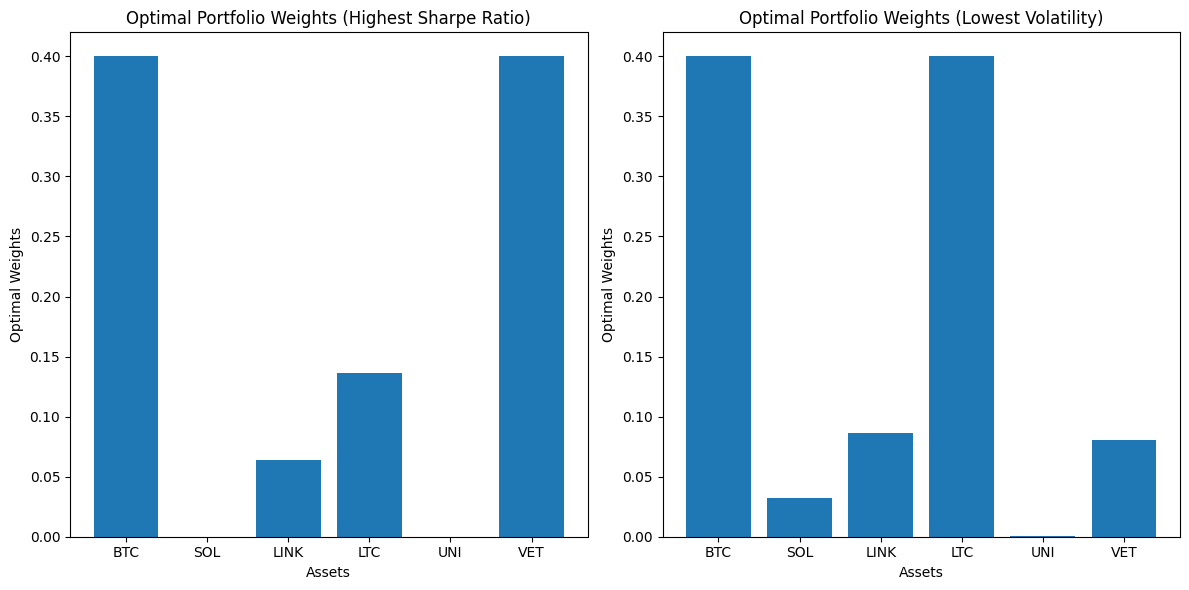

In [31]:
# Plotting optimal portfolio weights
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(tickers, optimal_weights_sharpe)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights (Highest Sharpe Ratio)')

plt.subplot(1, 2, 2)
plt.bar(tickers, optimal_weights_volatility)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights (Lowest Volatility)')

plt.tight_layout()
plt.show()
